*This notebook needs some additional packages that are not installed in the default python environment at CIP (they are if you used `requirements.txt` or run this notebook on binder). The following cell should make sure to install them: (let us know if there are problems)*

In [ ]:
import sys
import site

if "/software/opt" in sys.executable:
    # if in python environment at CIP install into user directory
    !pip install --user awkward uproot vector
    # give user directory priority
    sys.path.insert(0, site.getusersitepackages())
else:
    # otherwise just install the packages
    !pip install awkward uproot vector

# Awkward arrays

Numpy and pandas have one limitation: All data has to come in tabular form. However, sometimes you might encounter situations where you have lists of lists (of variable length), nested records, different types in the same list and potentially missing entries.

Things like this are very common in data analysis for particles physics where data schematically often looks like this:

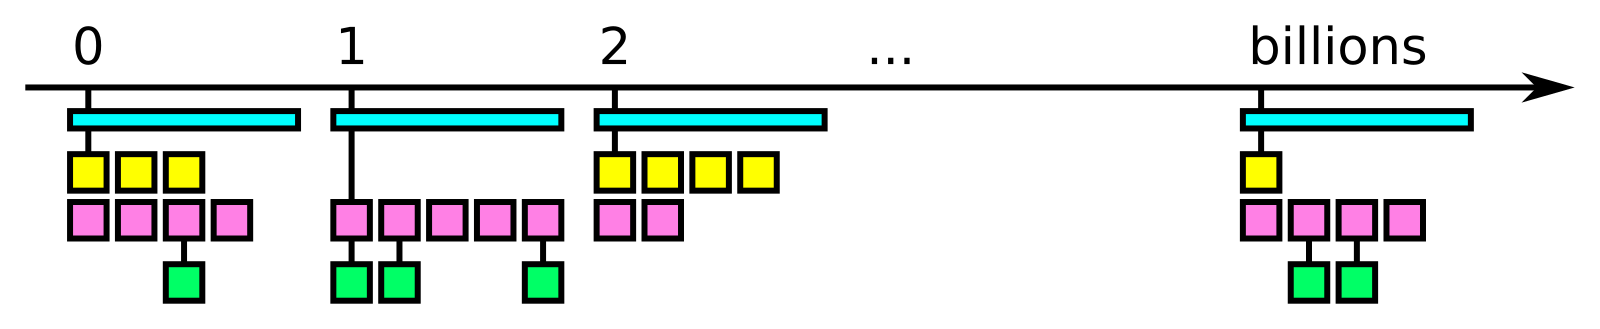

(image taken from a [tutorial from Jim Pivarski](https://github.com/jpivarski-talks/2020-07-13-pyhep2020-tutorial))

The numbers on top represent indices of collision events, the blue bars fixed quantities stored for each event and the other colorful boxes objects with variable length for each event. E.g. one event can have an arbitrary number of reconstructed particles of different type.

Dealing with this in pandas/numpy means working with multiple arrays and tables and doing many different operations for joining/grouping etc.

That's where awkward array comes into play to make our lives easier and allow for efficient processing of such data. For more information, see

http://awkward-array.org

https://github.com/scikit-hep/awkward-1.0#papers-and-talks-about-awkward-array

In [ ]:
import awkward as ak
import numpy as np

import matplotlib.pyplot as plt

We can have nested lists ("jagged arrays") of variable length:

In [ ]:
ak.Array([[1, 2, 3], [4], [], [5, 6, 7]])

In [ ]:
ak.Array([[[1], [2, 3]], [[], [], [4, 5]]])

Records (arrays of structures with multiple named fields, will internally be split into a structure of arrays)

In [ ]:
rec = ak.Array([{"a" : 5, "b": 6}, {"a": 7, "b": 8}])
rec

In [ ]:
rec.a

In [ ]:
rec.b

Missing values

In [ ]:
ak.Array([None, 1, 2, 3, None, 4])

Mixed types (unions)

In [ ]:
ak.Array([[1, 2], {"a": 4, "b": 5}, 3, None])

And arbitrary combinations of all this ...

Operations work on a per-array basis, very similar to numpy:

In [ ]:
a = ak.Array([[1, 2, 3], [4], [], [5, 6, 7]])

In [ ]:
a + 1

In [ ]:
a ** 2

`numpy ufuncs` broadcast to the elements of awkward arrays:

In [ ]:
np.sqrt(a)

Where for nested lists one can use the `axis` parameter in many constellations to do the same thing as for multi-dimensional numpy arrays

In [ ]:
ak.sum(a) # sum all elements in the array

In [ ]:
ak.sum(a, axis=0) # sum all first elements, all second elements, etc

In [ ]:
ak.sum(a, axis=1) # sum all elements for each list

In [ ]:
ak.min(a, axis=1) # minimum element in each list

In [ ]:
ak.num(a) # length of each list

There are also convenience functions for getting variable length lists back into rectangular numpy arrays, padded to a fixed size, filled with dummy values. This can be useful for e.g. machine learning applications when working with algorithms that expect inputs of fixed size. E.g. if we wanted to have our array lists to have a maximum length of 5 with missing values filled in as -1 we could do:

In [ ]:
ak.pad_none(a, 10).tolist()

In [ ]:
a_flat = ak.fill_none(ak.pad_none(a, 10), -1)
a_flat

Then you can use `ak.to_numpy` to convert arrays that are compatible with numpy back to numpy arrays:

In [ ]:
a_numpy = ak.to_numpy(a_flat)
a_numpy

This works often without copying. That means (although usually not recommended) that you can modify awkward arrays by converting to numpy.

While awkward arrays are read-only structures, numpy arrays can be modified:

In [ ]:
a_numpy[1, 1] = 42

In [ ]:
a_numpy

In [ ]:
a_flat.tolist()

Under the hood, these nested arrays are composed of contiguous arrays in memory to make computation efficient.

E.g. an array of lists is represented by offsets and content, we can inspect this by looking at the `layout`:

In [ ]:
a

In [ ]:
a.layout

In [ ]:
a.layout.form # just the overall structure

# Example: Chicago bikeroutes

A nice example for a dataset to work with Awkward array is the following geojson file of bikeroutes in Chicago. It is also used in the [introduction of the awkward array documentation](https://awkward-array.org/what-is-awkward.html).

In [ ]:
import urllib
import json

In [ ]:
url = "https://raw.githubusercontent.com/Chicago/osd-bike-routes/master/data/Bikeroutes.geojson"
bikeroutes_json = urllib.request.urlopen(url).read()

We can load this using the `json` module:

In [ ]:
bikeroutes_pyobj = json.loads(bikeroutes_json)

This will create a nested dictionary/list structure:

In [ ]:
type(bikeroutes_pyobj)

In [ ]:
bikeroutes_pyobj.keys()

In [ ]:
type(bikeroutes_pyobj["features"])

In [ ]:
bikeroutes_pyobj["features"][0]

Awkward array allows us to load this whole thing into a single array structure:

In [ ]:
bikeroutes = ak.from_json(bikeroutes_json)

We can navigate through the nested records (even if some of them are lists). For example, this will give us a 4-dimensional (partially variable length) list of coordinate values:

In [ ]:
bikeroutes.features.geometry.coordinates

In [ ]:
coordinates = bikeroutes.features.geometry.coordinates
coordinates

Similar to `axis`, awkward tries to generalize the notion of `ndim` to variable-length lists:

In [ ]:
coordinates.ndim

Looking at the list lengths at each dimension, we can figure out what they correspond to.

The last "axis" seems to always have length 2 - representing latitude/longitude coordinates:

In [ ]:
ak.num(coordinates, axis=-1)

In [ ]:
ak.all(ak.num(coordinates, axis=-1) == 2)

We can convert the last axis to a "regular array" to represent this in the structure:

In [ ]:
coordinates = ak.to_regular(coordinates, axis=-1)
coordinates

The second-to-last axis seems to be a variable length list of coordinates, representing points of route segments:

In [ ]:
ak.num(coordinates, axis=-2)

The third-to-last (second) axis seems to be almost always of length 1:

In [ ]:
ak.num(coordinates, axis=1)

What about the cases where it is not 1?

In [ ]:
coordinates[ak.num(coordinates, axis=1) != 1]

Let's look at these examples:

In [ ]:
special_routes = coordinates[ak.num(coordinates, axis=1) != 1]

In [ ]:
ak.num(special_routes, axis=-3)

Seems these are routes that have for some reason be split up into multiple segments.

Before doing anything sophisticated, let's just flatten all segments of all routes and plot the points as a scatter plot:

In [ ]:
x, y = ak.to_numpy(ak.flatten(ak.flatten(coordinates))).T
plt.scatter(x, y, s=0.1)

Next, we want to calculate the lengths of all bike routes. Quote from the awkward tutorial:

  > At Chicago’s latitude, one degree of longitude is 82.7 km and one degree of latitude is 111.1 km, which we can use   as conversion factors.

In [ ]:
longitude, latitude = coordinates[..., 0], coordinates[..., 1]
km_east = (longitude - np.mean(longitude)) * 82.7 # km/deg
km_north = (latitude - np.mean(latitude)) * 111.1 # km/deg
km_east, km_north

To get the lengths, we first to calculate the distances between each pair of consecutive coordinates

<div class="alert alert-block alert-success">
    <b>Exercise 1:</b> Calculate the distances between each pair of consecutive coordinates.<br><br>
    <b>Hint:</b> You can get the list of all coordinates, e.g. for the <code>km_east</code>  array, except the last one by <code>km_east[..., :-1]</code> and all but the first one by <code>km_east[..., 1:]</code><br>
    <b>Hint 2:</b> You'll need <code>np.sqrt</code>
</div>

<div class="alert alert-block alert-success">
    <b>Exercise 2:</b> Calculate the lengths of all segments and finally the lengths of all bike routes<br><br>
    <b>Hint:</b> Sum the pairwise distances along the last axis (twice)
</div>

<div class="alert alert-block alert-success">
    <b>Exercise 3:</b> Print out the 10 longest bike routes and their corresponding street names<br><br>
    <b>Hint:</b> Use <code>np.argsort</code> and use the resulting index to select both from the route lengths and from <code>bikeroutes.features.properties.STREET</code>
</div>

# Particle physics example: Reconstruct the Higgs Boson

Let's have a look at an example from particle physics. We will use a simulated dataset from the [ATLAS open data project](http://opendata.atlas.cern/):

In [ ]:
url = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/MC/mc_345060.ggH125_ZZ4lep.4lep.root"

This dataset comes in `.root` format, a commonly used file format in particle physics. You don't need to know details about this now, but there is a python library called `uproot` that can read data from these files into numpy or awkward arrays:

In [ ]:
import uproot
import io

In [ ]:
# will download ~50MB of data into memory
# uproot could in principle read data directly via http,
# but if we want to read the whole dataset, this is faster
data = urllib.request.urlopen(url).read()

In [ ]:
f = uproot.open(io.BytesIO(data))

The following command will read the data into a nested awkward array:

In [ ]:
events = f["mini"].arrays(how="zip")

In [ ]:
events.layout.form

There are some event level quantities like the `eventNumber`, the magnitude of the missing transverse momentum in each event, `met_et` etc

In [ ]:
events.eventNumber

In [ ]:
events.met_et

And then there are nested collections of variable length, like reconstructed leptons (electrons or muons), which contain record fields themselves, like the transverse momentum, `pt`:

In [ ]:
events.lep.pt

Different collections can have different length, e.g. in this case we have almost always 4 leptons, since these are simulated decays of

$$H\rightarrow ZZ\rightarrow \ell\ell\ell\ell$$

where $\ell\ell\ell\ell$ can be $e^{+}e^{-}\mu^{+}\mu^{-}$ or $e^{+}e^{-}e^{+}e^{-}$ or $\mu^{+}\mu^{-}\mu^{+}\mu^{-}$

In [ ]:
ak.num(events.lep)

In addition there can be an arbitrary number of "jets" (clustered streams of hadrons originating from a quark) in each event:

In [ ]:
ak.num(events.jet)

We will now try to calculate the invariant mass of all combinations of 4 leptons, which should peak around the Higgs boson mass.

For this we use the `vector` package

In [ ]:
import vector

`vector` makes use of another feature of awkward array, that is you can add "behavior" to records. This is used to add fields that are dynamically calculated from the data fields:

In [ ]:
p4 = vector.awk(events.lep[["pt", "eta", "phi", "E"]])

`p4` now represents a nested array of [Lorentz vectors](https://en.wikipedia.org/wiki/Four-vector):

In [ ]:
p4

In [ ]:
ak.num(p4)

We can for example dynamically calculate `px` and `py` (although our data is in `pt` and `phi` coordinates)

In [ ]:
p4.px, p4.py

To get all combinations of 4 leptons, we use the function `ak.combinations` which will return a nested list of tuples, containing the components of each combination. With `ak.unzip` we can split this up into arrays:

In [ ]:
l1, l2, l3, l4 = ak.unzip(ak.combinations(p4, 4))

The invariant mass can then be calculated like this:

In [ ]:
combined = l1 + l2 + l3 + l4

In [ ]:
combined

In [ ]:
combined.mass

This is still a nested array, since there might be multiple 4-lepton candidates per event. To get a flat list of all candidate masses we can do

In [ ]:
mass_array = ak.to_numpy(ak.flatten(combined.mass))
mass_array

Let's plot this as a histogram:

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
GeV = 1000.

In [ ]:
plt.hist(mass_array / GeV, bins=100, range=(100, 150));

We see a peak at 125 GeV!

This works nicely, since we only looked at simulated events of actual Higgs Boson decays. To find this peak in real data with huge amount of background mixed in one needs additional selection criteria.

See the following notebook for a more complete example:

https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/13-TeV-examples/uproot_python/HZZAnalysis.ipynb